# MLB 投手薪资等级分类（Decision Tree）Notebook 模板

逐格运行，便于调试与提交草稿。

In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 导入依赖与脚本函数

In [22]:
from capstone_group4 import (
    make_salary_tiers, infer_feature_columns,
    train_decision_tree_classifier,                
    train_decision_tree_classifier_simple,         
    plot_confusion, plot_tree_structure,          
    export_tree_rules, top_k_features_by_importance
)
import pandas as pd
import matplotlib.pyplot as plt

## 2. 读取数据（修改路径即可）

In [23]:
DATA_PATH = "mlb_salaries_and_pitching_stats_2011-2024.csv"
df = pd.read_csv(DATA_PATH)
len(df), df.shape

(21094, (21094, 18))

## 3. 快速窥视数据结构

In [24]:
sorted(df.columns.tolist())

['BB',
 'ER',
 'ERA',
 'G',
 'GS',
 'H',
 'HR',
 'IP',
 'L',
 'Player',
 'Player_Stats_Match',
 'R',
 'SO',
 'Total Cash',
 'W',
 'WAR',
 'WHIP',
 'Year']

In [25]:
df.head(3)

,Player,Year,Total Cash,Player_Stats_Match,WAR,W,L,G,GS,IP,H,R,ER,HR,BB,SO,ERA,WHIP
0,Kenley Jansen,2024,16000000,Kenley Jansen,1.3,4.0,2.0,54.0,0.0,54.2,38.0,20.0,20.0,4.0,20.0,62.0,3.29,1.061
1,Edwin Diaz,2024,11750000,Edwin Díaz,0.5,6.0,4.0,54.0,0.0,53.2,36.0,23.0,21.0,7.0,20.0,84.0,3.52,1.043
2,Chad Green,2024,10500000,Chad Green,0.7,4.0,6.0,53.0,0.0,53.1,41.0,20.0,19.0,8.0,14.0,46.0,3.21,1.031


In [26]:
df.dtypes

Player                 object
Year                    int64
Total Cash              int64
Player_Stats_Match     object
WAR                   float64
W                     float64
L                     float64
G                     float64
GS                    float64
IP                    float64
H                     float64
R                     float64
ER                    float64
HR                    float64
BB                    float64
SO                    float64
ERA                   float64
WHIP                  float64
dtype: object

## 4. 生成薪资分层（tiers）

In [27]:
df = make_salary_tiers(df, salary_col="Total Cash", n_tiers=4)
df["salary_tier"].value_counts(dropna=False)

salary_tier
T1    5275
T2    5274
T4    5274
T3    5271
Name: count, dtype: int64

## 5. EDA：缺失与分布概览

In [28]:
(df.isna().mean().sort_values(ascending=False)).head(20)

ERA                   0.408126
WHIP                  0.408126
Player_Stats_Match    0.407794
H                     0.407794
IP                    0.407794
R                     0.407794
WAR                   0.407794
G                     0.407794
GS                    0.407794
W                     0.407794
L                     0.407794
BB                    0.407794
HR                    0.407794
SO                    0.407794
ER                    0.407794
Total Cash            0.000000
Year                  0.000000
Player                0.000000
salary_tier           0.000000
dtype: float64

In [29]:
df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player,21094,3788,David Carpenter,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,21094.0,NaN,NaN,NaN,2017.588129,3.805154,2011.0,2015.0,2018.0,2021.0,2024.0
Total Cash,21094.0,NaN,NaN,NaN,2445882.754575,4596457.986889,2732.0,233885.0,552024.0,2262448.75,55000000.0
Player_Stats_Match,12492,2254,David Carpenter,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WAR,12492.0,NaN,NaN,NaN,0.562056,1.214501,-2.5,-0.1,0.2,1.0,9.7
W,12492.0,NaN,NaN,NaN,3.117115,3.70281,0.0,0.0,2.0,4.0,24.0
L,12492.0,NaN,NaN,NaN,3.139609,3.395011,0.0,0.0,2.0,5.0,19.0
G,12492.0,NaN,NaN,NaN,27.409062,20.401835,1.0,11.0,24.0,38.0,85.0
GS,12492.0,NaN,NaN,NaN,6.057157,10.029239,0.0,0.0,0.0,9.0,35.0
IP,12492.0,NaN,NaN,NaN,55.268412,52.188924,0.0,17.2,40.1,69.2,251.0


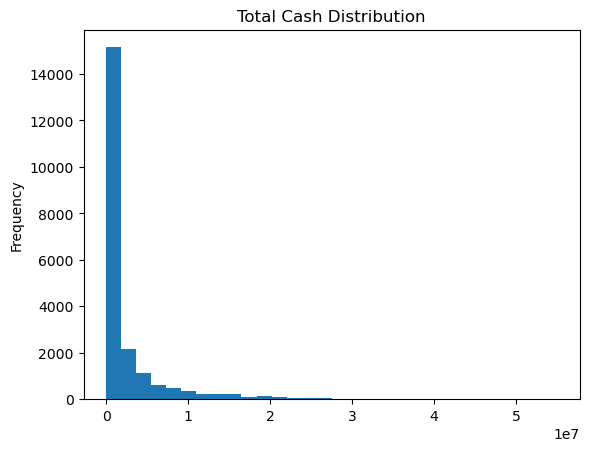

In [30]:
df["Total Cash"].plot(kind="hist", bins=30, title="Total Cash Distribution")
plt.show()

## 6. 选择特征列（自动 + 手动微调）

In [31]:
feature_cols = infer_feature_columns(df, target_col="salary_tier")
feature_cols

['WAR',
 'W',
 'L',
 'G',
 'GS',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'ERA',
 'WHIP']

In [32]:
# 手动微调（例如不使用 Year）
feature_cols = [c for c in feature_cols if c not in ["Year"]]
feature_cols

['WAR',
 'W',
 'L',
 'G',
 'GS',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'ERA',
 'WHIP']

## 7. 训练 & 调参（决策树）

In [34]:
model, (X_test, y_test, y_pred), summary = train_decision_tree_classifier(
    df=df,
    feature_cols=feature_cols,
    target_col="salary_tier",
    scoring="f1_macro",    # 可改 "accuracy" 或 "balanced_accuracy"
    # param_grid=None      # 留空就用函数里的默认网格
)

# 打印结果（字段名与 simple 版不同）
print("BEST PARAMS:", summary["best_params"])
print("CV f1_macro:", summary["cv_best_score"])
print("Holdout Acc:", summary["holdout_accuracy"])
print("Holdout F1_macro:", summary["holdout_f1_macro"])
print(summary["classification_report"])


BEST PARAMS: {'clf__ccp_alpha': 0.0, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CV f1_macro: 0.4331513876903891
Holdout Acc: 0.45200284427589477
Holdout F1_macro: 0.44432147235039676
              precision    recall  f1-score   support

          T1      0.673     0.445     0.536      1055
          T2      0.483     0.285     0.359      1055
          T3      0.524     0.325     0.401      1054
          T4      0.354     0.752     0.481      1055

    accuracy                          0.452      4219
   macro avg      0.508     0.452     0.444      4219
weighted avg      0.508     0.452     0.444      4219



## 8. 评估指标与可视化

In [39]:
print("BEST PARAMS:", summary["best_params"])
print("CV f1_macro:", summary["cv_best_score"])
print("Holdout Accuracy:", summary["holdout_accuracy"])
print("Holdout F1_macro:", summary["holdout_f1_macro"])
print(summary["classification_report"])

# 想看真正用到的 ccp_alpha：
print("Chosen ccp_alpha:", model.named_steps["clf"].ccp_alpha)

BEST PARAMS: {'clf__ccp_alpha': 0.0, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CV f1_macro: 0.4331513876903891
Holdout Accuracy: 0.45200284427589477
Holdout F1_macro: 0.44432147235039676
              precision    recall  f1-score   support

          T1      0.673     0.445     0.536      1055
          T2      0.483     0.285     0.359      1055
          T3      0.524     0.325     0.401      1054
          T4      0.354     0.752     0.481      1055

    accuracy                          0.452      4219
   macro avg      0.508     0.452     0.444      4219
weighted avg      0.508     0.452     0.444      4219

Chosen ccp_alpha: 0.0


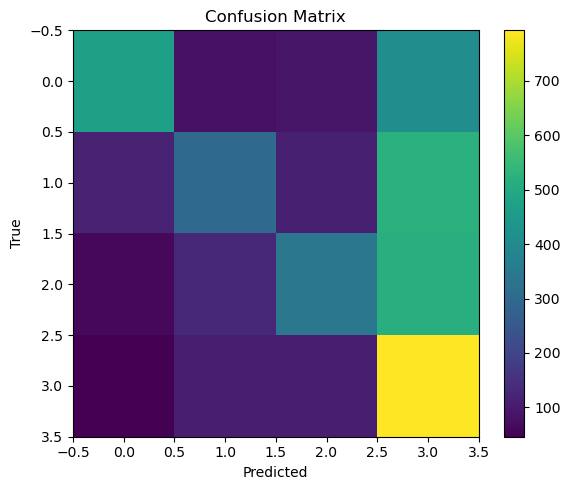

In [40]:
plot_confusion(y_test, y_pred)  # 可改 normalize='true'

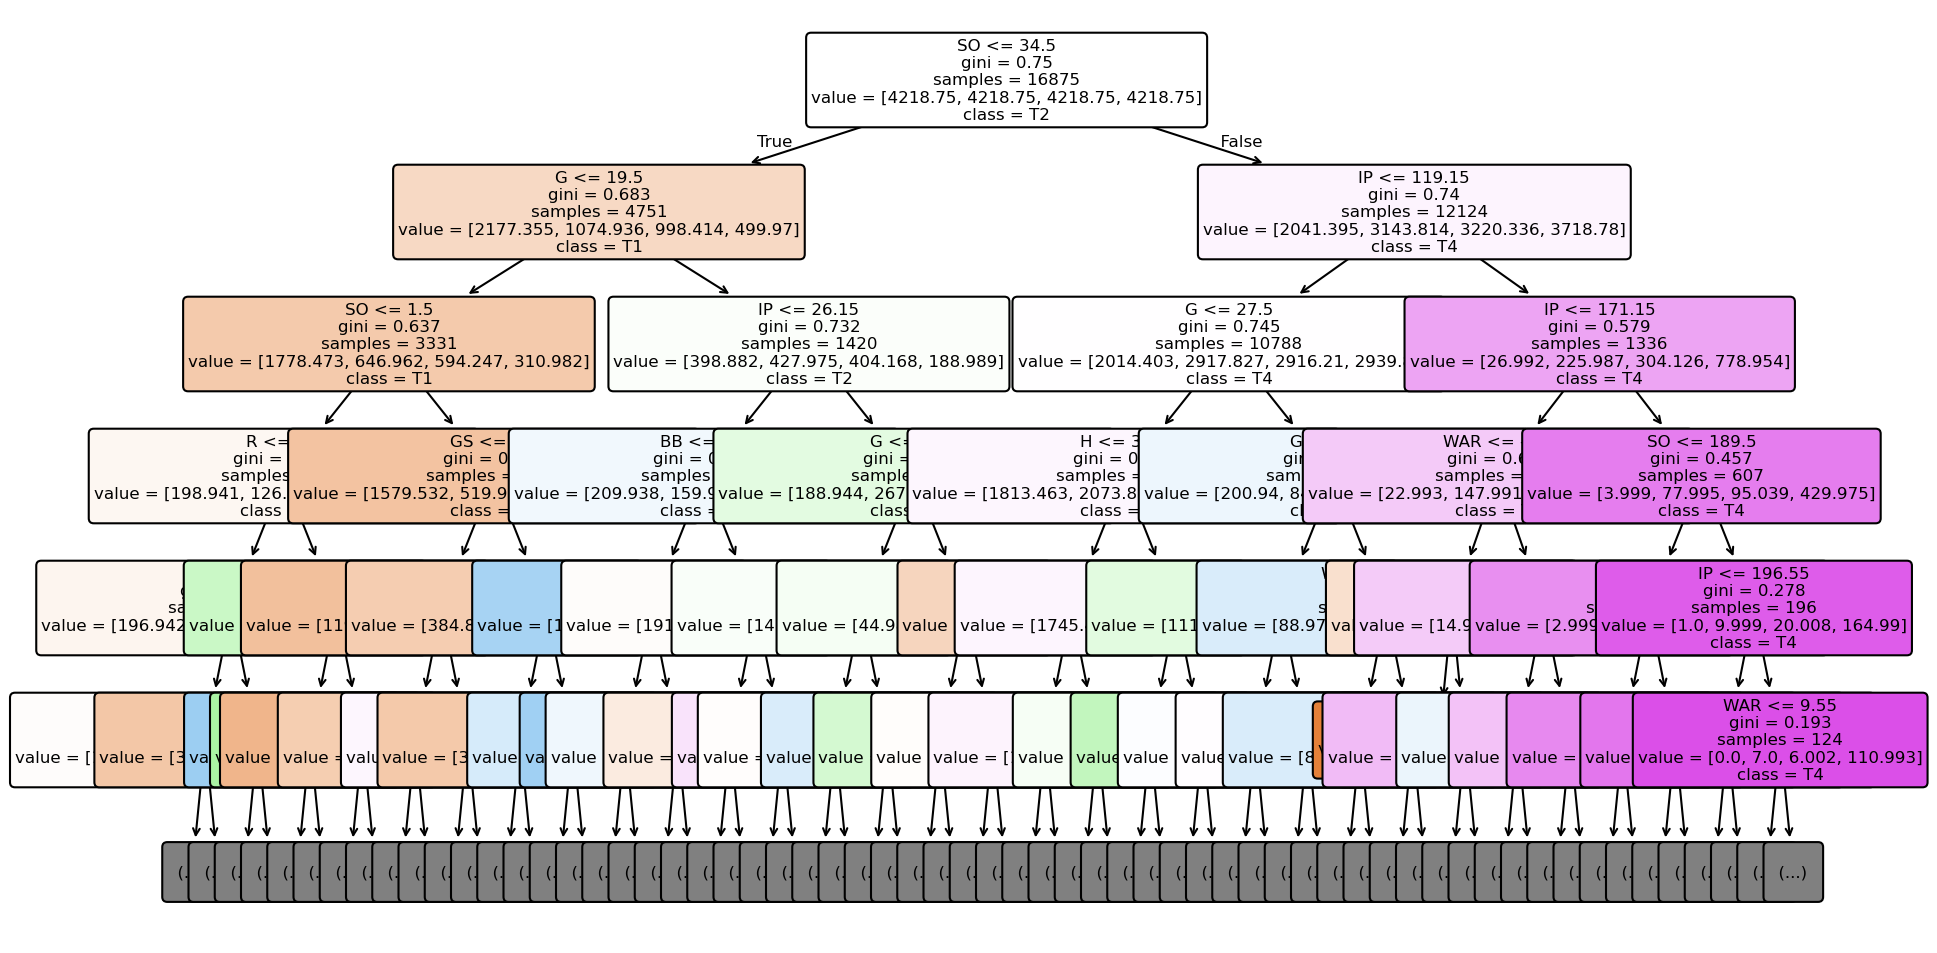

In [41]:
plot_tree_structure(model, feature_cols, max_depth_to_plot=5)

## 9. 特征重要性（可选）

In [42]:
clf = model.named_steps["clf"]
importances = clf.feature_importances_
imp_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)
imp_df.head(15)

,feature,importance
11,SO,0.162780
13,WHIP,0.104465
5,IP,0.103221
3,G,0.094364
10,BB,0.077236
6,H,0.070559
12,ERA,0.066792
0,WAR,0.066506
9,HR,0.056456
7,R,0.047228


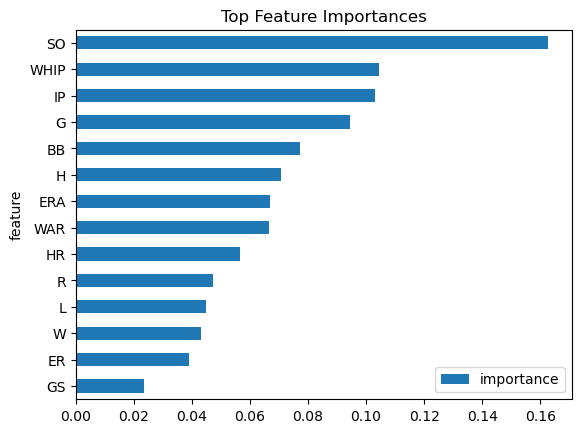

In [43]:
ax = imp_df.head(15).plot(kind="barh", x="feature", y="importance", title="Top Feature Importances")
ax.invert_yaxis()

## 10. 保存模型（可选）

In [ ]:
import joblib
joblib.dump(model, "salary_tier_tree_pipeline.joblib")

## 11. 推理示例（可选）

In [47]:
sample = df.sample(5, random_state=45)
pred = model.predict(sample[feature_cols])
sample_out = pd.DataFrame({
    "Player": sample.get("Player", pd.Series([None]*len(sample))),
    "TrueTier": sample["salary_tier"].values,
    "PredTier": pred
})
sample_out

,Player,TrueTier,PredTier
18604,Shin-Soo Choo,T4,T4
6587,Roenis Elias,T3,T4
14911,Dustin Ackley,T3,T4
11548,Franklin Gutierrez,T4,T4
2605,Francisco Perez,T1,T1


In [48]:
clf = model.named_steps["clf"]
params_text = (
    f"Parameters: max_depth = {clf.max_depth}, "
    f"min_samples_leaf = {clf.min_samples_leaf}, "
    f"ccp_alpha = {clf.ccp_alpha:.6g}, "
    f"criterion = {clf.criterion}"
)
print(params_text)

Parameters: max_depth = None, min_samples_leaf = 1, ccp_alpha = 0, criterion = gini
